In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
from scipy.interpolate import interp1d

import numpy as np
#from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import LambdaCDM
cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo = cosmoLambdaCDM

from astropy.cosmology import Planck18

from scipy.integrate import quad, dblquad
from scipy.stats import gengamma, rayleigh
from scipy.special import gamma

from numba import njit, jit
from ler.utils import rejection_sample
from scipy.interpolate import interp1d

In [13]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation(z_max=40, cosmology=cosmoLambdaCDM,) 

ImportError: cannot import name 'create_inv_cdf' from 'ler.utils' (/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/utils/__init__.py)

In [21]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

## Difference between $\phi_{loc}^{Bernardi}$ and $\Gamma$ distribution from Haris

In [181]:
size = 10000

# philocbernardi
# normalised pdf
sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIS2 = quad(sigma_pdf_SIS2, 1, 600)[0]
sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIS2

def sample_sigma_SIS2(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS2, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma

# gen_gamma
# normalised pdf
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS1 = quad(sigma_pdf_SIS1, 1, 600)[0]
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS1

def sample_sigma_SIS1(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma


# gamma distribition
def gammafunction(sig, alpha=2.32, beta=2.67, sigstar=161.):
    return (sig/sigstar)**(alpha)*np.exp(-(sig/sigstar)**beta)*(beta/gamma(alpha/beta))/sig

sigma_pdf_SIS3 = lambda sig_: gammafunction(sig_)
sigma_pdf_norm_SIS3 = quad(sigma_pdf_SIS3, 1, 600)[0]
sigma_pdf_SIS3 = lambda sig_: gammafunction(sig_)/sigma_pdf_norm_SIS3

def sample_sigma_SIS3(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS3, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma

sample1 = sample_sigma_SIS2(size=size)
#sample2 = gengamma.rvs(a=2.32 / 2.67, c=2.67, size=size)*161.
sample2 = sample_sigma_SIS1(size=size)
sample3 = sample_sigma_SIS3(size=size)

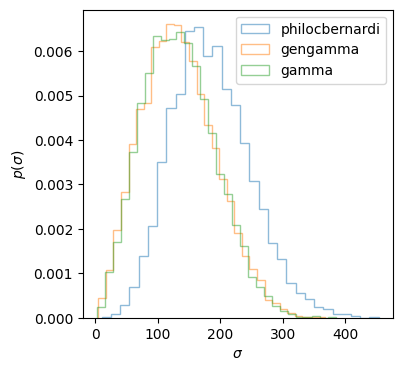

In [182]:
# plot hist
plt.figure(figsize=(4, 4))
plt.hist(sample1, bins=30, density=True, label='philocbernardi', alpha=0.5, histtype='step')
plt.hist(sample2, bins=30, density=True, label='gengamma', alpha=0.5, histtype='step')
plt.hist(sample3, bins=30, density=True, label='gamma', alpha=0.5, histtype='step')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma)$')
plt.legend()
plt.show()


* this quite different 
* higher sigma will lead to higher optical depth

In [9]:
@jit
def cross_section_SIS(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@njit
def phi_cut_SIE(q):
    n = len(q)
    result = np.empty(n)
    for i in range(n):
        val = q[i]
        if 0.01 < val < 0.99:
            result[i] = (2 * np.pi * val * np.log(val)) / (val ** 2 - 1)
        elif val < 0.01:
            result[i] = -2 * (np.pi * np.log(val)) * val
        else:
            result[i] = np.pi
    return result/np.pi

## 0. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[0,600]$
* Oguri style

In [10]:
sigma_pdf_SIE0 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIE0 = quad(sigma_pdf_SIE0, 1, 600)[0]
sigma_pdf_SIE0 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIE0

def sample_sigma_q_SIE0(sigma_lim=[1,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE0, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE0(zl, zs):
    sigma, q = sample_sigma_q_SIE0(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE0(zs):
    result = quad(integrand_SIE0, 0, zs, args=(zs))

    return result[0]

In [11]:
optical_depth_SIE0(1.5)

INFO:numba.core.transforms:finding looplift candidates


0.0009478015670318382

## 1. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Oguri style

In [12]:

sigma_pdf_SIE1 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIE1 = quad(sigma_pdf_SIE1, 60, 600)[0]
sigma_pdf_SIE1 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIE1

def sample_sigma_q_SIE1(sigma_lim=[60,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE1(zl, zs):
    sigma, q = sample_sigma_q_SIE1(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE1(zs):
    result = quad(integrand_SIE1, 0, zs, args=(zs))

    return result[0]

## 2. SIE

* $\sigma_v$ dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* normalization of $z$ in the range $[0,3]$
* Oguri style

In [13]:
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
sigma_pdf_norm_SIE2 = dblquad(sigma_pdf_SIE2, 0, 3, 60, 600)[0]
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)/sigma_pdf_norm_SIE2

def sample_sigma_q_SIE2(zl, sigma_lim=[60,600], size=200):

    sigma = test.conditional_rejection_sample(sigma_pdf_SIE2,sigma_lim[0],sigma_lim[1],zl,size=size,chunk_size=1000)
    
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q

def integrand_SIE2(zl, zs):
    sigma, q = sample_sigma_q_SIE2(zl,size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIE2(zs):
    result = quad(integrand_SIE2, 0, zs, args=(zs))

    return result[0]

## 3. SIS

* $\sigma_v$ independent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Haris style

In [14]:
# normalised pdf
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS1 = quad(sigma_pdf_SIS1, 60, 600)[0]
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS1

def sample_sigma_SIS1(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS1(zl, zs):
    sigma = sample_sigma_SIS1(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS1(zs):
    result = quad(integrand_SIS1, 0, zs, args=(zs))

    return result[0]

In [15]:
optical_depth_SIS1(1.5)

0.0003908674094551756

In [25]:
# normalised pdf
sigma_pdf_SIS3 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS3 = quad(sigma_pdf_SIS3, 0, 600)[0]
sigma_pdf_SIS3 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS3

def sample_sigma_SIS3(sigma_lim=[0,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS3, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS3(zl, zs):
    sigma = sample_sigma_SIS3(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS3(zs):
    result = quad(integrand_SIS3, 0, zs, args=(zs))

    return result[0]

In [26]:
optical_depth_SIS3(1.5)

0.00034886195593006856

In [18]:
# normalised pdf
sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIS2 = quad(sigma_pdf_SIS2, 60, 600)[0]
sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIS2

def sample_sigma_SIS2(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS2, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS2(zl, zs):
    sigma = sample_sigma_SIS2(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS2(zs):
    result = quad(integrand_SIS2, 0, zs, args=(zs))

    return result[0]

In [19]:
optical_depth_SIS2(1.5)

0.000984251990571789

In [20]:
def strong_lensing_optical_depth_SIS(zs):
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return 4.17*1e-6*(Dc) ** 3

strong_lensing_optical_depth_SIS(zs=1.5)

0.0003465350907932671

* normalization matters

### Velcity dispersion comparision

In [26]:
sigma1, q1 = sample_sigma_q_SIE1(size=1000)

In [27]:
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=1000)

In [30]:
sigma3 = sample_sigma_SIS1(sigma_lim=[60,600], size=200)

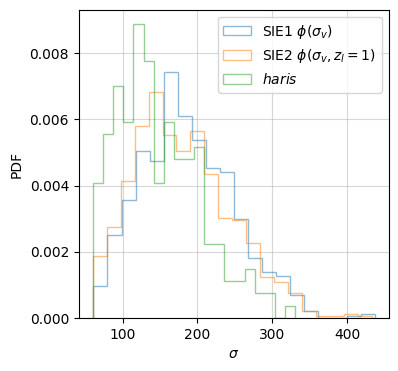

In [31]:
# all three models are normalised, sigma->[60,600]
# plot comparison
plt.figure(figsize=(4,4))
plt.hist(sigma1, bins=20, alpha=0.5, label=r'SIE1 $\phi(\sigma_v)$', density=True, histtype='step')
plt.hist(sigma2, bins=20, alpha=0.5, label=r'SIE2 $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')
plt.hist(sigma3, bins=20, alpha=0.5, label=r'$haris$', density=True, histtype='step')
plt.xlabel(r'$\sigma$')
plt.ylabel('PDF')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* gamma distribution taken by Haris is different as compare to Oguri

### Optical depth comparision

In [21]:
zs = np.linspace(0.001, 2, 10)
tau_sie1 = np.array([optical_depth_SIE1(zs=z) for z in zs])

In [22]:
# takes 2m 58s for 10 zs
zs = np.linspace(0.001, 2, 10)
tau_sie2 = np.array([optical_depth_SIE2(zs=z) for z in zs])

In [23]:
zs = np.linspace(0.001, 2, 10)
tau_sis1 = np.array([optical_depth_SIS1(zs=z) for z in zs])


In [24]:
zs = np.linspace(0.001, 2, 10)
tau_sis2 = np.array([optical_depth_SIS2(zs=z) for z in zs])

In [27]:
zs = np.linspace(0.001, 2, 10)
tau_sis3 = np.array([optical_depth_SIS3(zs=z) for z in zs])

In [28]:
zs = np.linspace(0.001, 2, 10)
tau_haris = strong_lensing_optical_depth_SIS(zs)

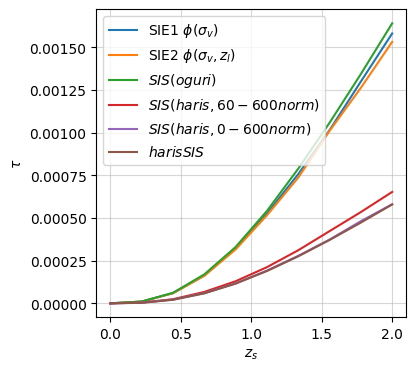

In [31]:
# plot
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sie1, label=r'SIE1 $\phi(\sigma_v)$')
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')
plt.plot(zs, tau_sis2, label=r'$SIS (oguri)$')
plt.plot(zs, tau_sis1, label=r'$SIS (haris, 60-600norm)$')
plt.plot(zs, tau_sis3, label=r'$SIS (haris, 0-600norm)$')
plt.plot(zs, tau_haris, label=r'$haris SIS$')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Conclusion

| Model | Lens Model | $\sigma_v$ Dependency on $z$ | Normalization of $\sigma_v$ | Normalization of $z$ | Sigma Cut Dependency | Gamma Distribution Source |
|-------|------------|-------------------------------|-----------------------------|----------------------|----------------------|---------------------------|
| 1     | SIE        | No                           | [60, 600]                   | None                 | Mass Ratio           | Oguri                    |
| 2     | SIE        | Yes                          | [60, 600]                   | [0, 3]               | Mass Ratio           | Oguri                    |
| 3     | SIS        | No                           | [60, 600]                   | None               | Mass Ratio           | Oguri                    |
| 4     | SIS        | No                           | [60, 600]                   | None                 | None                 | Haris                    |
| 4     | SIS        | No                           | [0, 600]                   | None                 | None                 | Haris                    |
| 5     | SIS        | No                           | None                        | None                 | None                 | Haris                    |



* The difference mainly comes from the velocity dispersion distribution shape and also the normalization
* The difference between the model1/2/3 is not very large.
* Between model4 and model5/model6, the difference is significant, which means the normalization range of velocity dispersion is important.
* model 5 and model 6 are the same, which means the normalization of redshift is not important if the range is the the same. This also proves that haris model underestimates the velocity dispersion and hence the optical depth.

## Check for $z_l$ distribution  

* fixed $\sigma_v=161 km/s$ 

In [224]:
# use interpolation to find the pdf of zl
def zl_pdf_SIE(zl_list, zs=5, sigma=161):
    sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
    zl = np.linspace(0.001, zs, 100)
    sigma = np.ones(len(zl))*sigma
    zl_pdf_unnorm = interp1d(zl, sigma_pdf_SIE2(sigma,zl), kind='cubic')
    zl_norm = quad(zl_pdf_unnorm, 0.001, zs)[0]

    return zl_pdf_unnorm(zl_list)/zl_norm

In [220]:
zl_lens = lens.sample_lens_redshifts(np.ones(1000)*2)

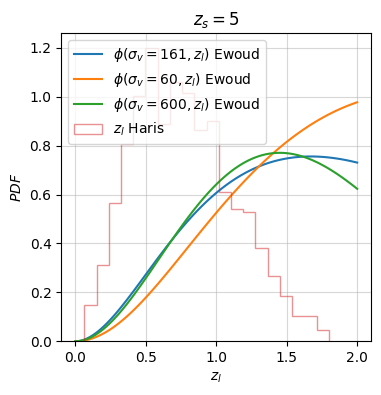

In [227]:
# plot
zl = np.linspace(0.001, 2, 100)
plt.figure(figsize=(4,4))
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=161), label=r'$\phi(\sigma_v=161,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=60), label=r'$\phi(\sigma_v=60,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=600), label=r'$\phi(\sigma_v=600,z_l)$ Ewoud')
plt.hist(zl_lens, bins=20, alpha=0.5, label=r'$z_l$ Haris', density=True, histtype='step')
plt.title(r'$z_s=5$')
plt.xlabel(r'$z_l$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* Haris and Oguri style is different

## Validation of the interpolation method of sigma sampling

In [2]:
import test2
#reload(test)
import importlib
importlib.reload(test2)

<module 'test2' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test2.py'>

In [3]:
vd = test2.VelocityDispersionSampler()

Inveverse CDF of Velocity dispersion for inverse transform sampling will be loaded from ./interpolator_pickle/vel_disp/inv_cdf_0.pickle


In [ ]:
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')

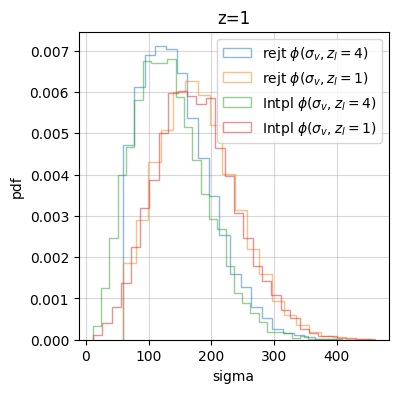

In [45]:
# plot velo disp
plt.figure(figsize=(4,4))

sigma2, q2 = sample_sigma_q_SIE2(zl=4, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=4)$', density=True, histtype='step')
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')

sample = vd.sample_vel_disp(4, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=4)$')
sample = vd.sample_vel_disp(1.0, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=1)$')

plt.xlabel('sigma')
plt.ylabel('pdf')
plt.title('z=1')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* It's perfect 

In [1]:
# plot optical depth with zl pdf

def optical_depth_SIS(self, zs):
    """
    Function to compute the strong lensing optical depth (SIS)

    Parameters
    ----------
        zs : `float`
            source redshifts

    Returns
    -------
        tau : `float`
            strong lensing optical depth

    """
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = lens.z_to_Dc(zs) * 1e-3  # 1e-3 converts Mpc to Gpc

    return (Dc / 62.2) ** 3

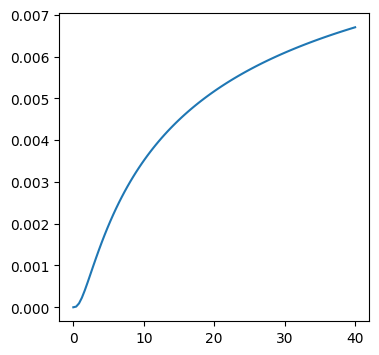

In [6]:
# plot optical depth with zl pdf (sis only)
plt.figure(figsize=(4,4))
zs = np.linspace(0.001, 40, 100)
tau = strong_lensing_optical_depth_SIS(zs)
plt.plot(zs, tau, label=r'$\tau$ SIS')
plt.show()


In [ ]:

        if lens_type == "epl_galaxy":
            sampler_priors_ = dict(
                source_parameters="sample_strongly_lensed_source_parameters",
                lens_redshift="lens_redshift_SDSS_catalogue",
                velocity_dispersion="velocity_dispersion_gengamma",
                axis_ratio="axis_ratio_rayleigh",
                axis_rotation_angle="axis_rotation_angle_uniform",
                shear="shear_norm",
                mass_density_spectral_index="mass_density_spectral_index_normal",
            )
            sampler_priors_params_ = dict(
                source_parameters=None,
                lens_redshift=dict(zs=self.lens_parameters["zs"]),
                velocity_dispersion=dict(a=2.32 / 2.67, c=2.67),
                axis_ratio=dict(sigma=self.lens_parameters["sigma"]),
                axis_rotation_angle=dict(phi_min=0.0, phi_max=2 * np.pi),
                shear=dict(scale=0.05),
                mass_density_spectral_index=dict(mean=2.0, std=0.2),
            )
        else:
            raise ValueError("lens_type not recognized")
        
        # update the priors if input is given
        if sampler_priors:
            sampler_priors_.update(sampler_priors)
        if sampler_priors_params:
            sampler_priors_params_.update(sampler_priors_params)

        # dict of sampler names with description
        lens_sampler_names_ = dict(
            sample_source_parameters="source parameters conditioned on the source being strongly lensed",
            sample_lens_redshift="lens redshift",
            sample_velocity_dispersion="velocity dispersion of elliptical galaxy",
            sample_axis_ratio="axis ratio of elliptical galaxy",
            sample_axis_rotation_angle="axis rotation angle of elliptical galaxy    ",
            sample_shear="shear of elliptical galaxy",
            sample_mass_density_spectral_index="mass density spectral index of elliptical power-law galaxy",
        )

In [1]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation()

In [2]:
lens.sample_source_redshift_sl(size=10)

array([2.76702821, 6.43989511, 8.3599859 , 1.47381175, 1.58238155,
       3.90471544, 5.03577095, 4.45137479, 3.79623267, 5.2530226 ])

In [3]:
lens.lens_param_samplers_params

{'source_redshift_sl': None,
 'lens_redshift': None,
 'velocity_dispersion': {'a': 0.8689138576779026, 'c': 2.67},
 'axis_ratio': {'q_min': 0.2},
 'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 6.283185307179586},
 'shear': {'scale': 0.05},
 'mass_density_spectral_index': {'mean': 2.0, 'std': 0.2},
 'source_parameters': None}

In [4]:
# initializing samplers
# self.sample_source_redshift_sl = self.lens_param_samplers["source_redshift_sl"]
# self.sample_lens_redshift = self.lens_param_samplers["lens_redshift"]
# self.sample_velocity_dispersion = self.lens_param_samplers[
#     "velocity_dispersion"
# ]
# self.sample_axis_ratio = self.lens_param_samplers["axis_ratio"]
# self.sample_axis_rotation_angle = self.lens_param_samplers[
#     "axis_rotation_angle"
# ]
# self.sample_shear = self.lens_param_samplers["shear"]
# self.sample_mass_density_spectral_index = self.lens_param_samplers[
#     "mass_density_spectral_index"
# ]
# self.sample_source_parameters = self.lens_param_samplers["source_parameters"]

In [2]:
test = lens.sample_all_routine1(size=1000)

current sampled size 33
current sampled size 77
current sampled size 114
current sampled size 158
current sampled size 182
current sampled size 230
current sampled size 278
current sampled size 303
current sampled size 350
current sampled size 401
current sampled size 426
current sampled size 444
current sampled size 498
current sampled size 533
current sampled size 577
current sampled size 616
current sampled size 659
current sampled size 682
current sampled size 721
current sampled size 769
current sampled size 793
current sampled size 832
current sampled size 862
current sampled size 919
current sampled size 960
current sampled size 982


In [3]:
test.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'ra', 'dec'])

In [7]:
from ler.gw_source_population import SourceGalaxyPopulationModel

cbc = SourceGalaxyPopulationModel()

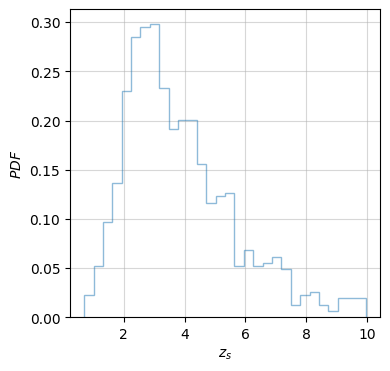

In [4]:
import matplotlib.pyplot as plt

zs = test["zs"]
# plot hist
plt.figure(figsize=(4,4))
plt.hist(zs, bins=30, alpha=0.5, density=True, histtype='step')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.show()

In [78]:
from astropy.cosmology import LambdaCDM
from astropy.cosmology import Planck18

In [79]:
# cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# cosmo = cosmoLambdaCDM
Planck18.comoving_distance(1.2)

<Quantity 3864.91527421 Mpc>

In [80]:
# change planck18 init values
planck = Planck18(H0=60)

TypeError: 'FlatLambdaCDM' object is not callable

In [114]:
def create_func_pdf_cdf_invcdf(x, y, category="function"):
    # remove idx of nan values
    idx = np.argwhere(np.isnan(y))
    x = np.delete(x, idx)
    y = np.delete(y, idx)
    # create pdf with interpolation
    pdf_unorm = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    if category == "function":
        return pdf_unorm
    if category == "function_inverse":
        # create inverse function
        return interp1d(y, x, kind="cubic", fill_value="extrapolate")

    xlim = [x[0], x[-1]]
    norm = quad(pdf_unorm, xlim[0], xlim[1])[0]
    y = y / norm
    # normalize the pdf
    pdf = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    if category == "pdf" or category == None:
        return pdf
    # create cdf
    cdf = lambda x: quad(pdf, xlim[0], x)[0]
    # get all values of cdf
    cdf_values = np.array([cdf(x_) for x_ in x])
    cdf_ = interp1d(x, cdf_values, kind="cubic", fill_value="extrapolate")
    if category == "cdf":
        return cdf_
    # create inverse cdf
    inv_cdf = interp1d(cdf_values, x, kind="cubic", fill_value="extrapolate")
    if category == "inv_cdf":
        return inv_cdf
    if category == "all":
        return([pdf, cdf_, inv_cdf])
    
def create_conditioned_pdf_cdf_invcdf(x, conditioned_y, pdf_func, category="pdf"):
    """
    pdf_func is the function to calculate the pdf of x given y
    x is an array and the output of pdf_func is an array
    y is the condition
    we consider parameter plane of x and y
    """

    list = []
    for y in conditioned_y:
        phi = pdf_func(x,y)
        # creating the interpolator
        list.append(create_func_pdf_cdf_invcdf(x,phi, category=category))
    return list

def interpolator_from_pickle(
    param_dict_given, directory, sub_directory, name, x, pdf_func, conditioned_y=None, dimension=1,category="pdf", create_new=False
):
    """
    Function to decide which interpolator to use.
    """

    # check first whether the directory, subdirectory and pickle exist
    path_inv_cdf, it_exist = interpolator_pickle_path(
        param_dict_given=param_dict_given,
        directory=directory,
        sub_directory=sub_directory,
        interpolator_name=name,
    )
    if create_new:
        it_exist = False
    if it_exist:
        print(f"{name} interpolator will be loaded from {path_inv_cdf}")
        # load the interpolator
        with open(path_inv_cdf, "rb") as handle:
            interpolator = pickle.load(handle)
        return interpolator
    else:
        print(f"{name} interpolator will be generated at {path_inv_cdf}")

        # create the interpolator
        if dimension==1:
            y = pdf_func(x)
            interpolator = create_func_pdf_cdf_invcdf(x, y, category=category)
        elif dimension==2:
            interpolator = create_conditioned_pdf_cdf_invcdf(x, conditioned_y, pdf_func, category=category)
        else:
            raise ValueError("The dimension is not supported.")
        # save the interpolator
        with open(path_inv_cdf, "wb") as handle:
            pickle.dump(interpolator, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return interpolator

def interpolator_pickle_path(
    param_dict_given,
    directory,
    sub_directory,
    interpolator_name,
):
    """
    Function to create the interpolator pickle file path for velocity dispersion.
    """

    # check the dir 'interpolator' exist
    full_dir = directory + "/" + sub_directory
    if not os.path.exists(directory):
        os.makedirs(directory)
        os.makedirs(full_dir)
    else:
        if not os.path.exists(full_dir):
            os.makedirs(full_dir)

    # check if param_dict_list.pickle exists
    path1 = full_dir + "/init_dict.pickle"
    if not os.path.exists(path1):
        dict_list = []
        with open(path1, "wb") as handle:
            pickle.dump(dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # check if the input dict is the same as one of the dict inside the pickle file
    param_dict_stored = pickle.load(open(path1, "rb"))

    path2 = full_dir
    len_ = len(param_dict_stored)
    if param_dict_given in param_dict_stored:
        idx = param_dict_stored.index(param_dict_given)
        # load the interpolator
        path_inv_cdf = path2 + "/" + interpolator_name + "_" + str(idx) + ".pickle"
        # there will be exception if the file is deleted by mistake
        if os.path.exists(path_inv_cdf):
            it_exist = True
        else:
            it_exist = False
    else:
        it_exist = False
        path_inv_cdf = path2 + "/" + interpolator_name + "_" + str(len_) + ".pickle"
        param_dict_stored.append(param_dict_given)
        with open(path1, "wb") as handle:
            pickle.dump(param_dict_stored, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return path_inv_cdf, it_exist

In [82]:
z_max = 10.
z = np.linspace(0.001, z_max, 500)  # red-shift
Dc = cosmoLambdaCDM.comoving_distance(z).value  # co-moving distance in Mpc
z_to_Dc = interp1d(z, Dc, kind="cubic", fill_value="extrapolate")
Dc_to_z = interp1d(Dc, z, kind="cubic")

In [160]:
z_to_Dc_ = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=z_max, cosmology=cosmoLambdaCDM), 
    directory="./interpolator",
    sub_directory="z_to_Dc", 
    name="z_to_Dc",
    x = np.linspace(0.001, 10., 500),
    pdf_func= lambda x: cosmoLambdaCDM.comoving_distance(x).value, 
    conditioned_y=None, 
    dimension=1,
    category="function",
    create_new=True,
)

z_to_Dc interpolator will be generated at ./interpolator/z_to_Dc/z_to_Dc_1.pickle


In [161]:
Dc_to_z_ = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=z_max, cosmology=cosmoLambdaCDM), 
    directory="./interpolator",
    sub_directory="Dc_to_z", 
    name="Dc_to_z",
    x = np.linspace(0.001, 10., 500),
    pdf_func= lambda x: cosmoLambdaCDM.comoving_distance(x).value, 
    conditioned_y=None, 
    dimension=1,
    category="function_inverse",
    create_new=True,
)

Dc_to_z interpolator will be generated at ./interpolator/Dc_to_z/Dc_to_z_1.pickle


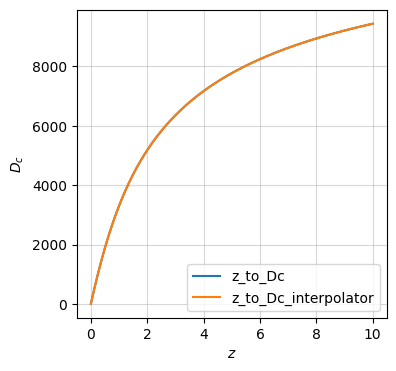

In [162]:
# plot z to Dc
plt.figure(figsize=(4,4))
plt.plot(z, z_to_Dc(z), label="z_to_Dc")
plt.plot(z, z_to_Dc_(z), label="z_to_Dc_interpolator")
plt.xlabel(r'$z$')
plt.ylabel(r'$D_c$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

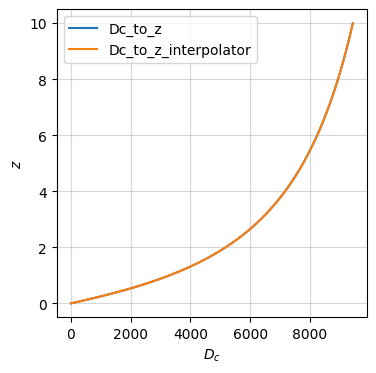

In [163]:
# plot Dc to z
plt.figure(figsize=(4,4))
plt.plot(Dc, Dc_to_z(Dc), label="Dc_to_z")
plt.plot(Dc, Dc_to_z_(Dc), label="Dc_to_z_interpolator")
plt.xlabel(r'$D_c$')
plt.ylabel(r'$z$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()


In [76]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

In [144]:
vd_conditioned_on_zl = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=10., vd_min=60., vd_max=600., cosmology=cosmoLambdaCDM),
    directory="./interpolator",
    sub_directory="vd_conditioned_on_zl", 
    name="vd_conditioned_on_zl",
    x = np.linspace(60., 600., 50),
    pdf_func= test.phi, 
    conditioned_y=np.linspace(0.001, 10., 100), 
    dimension=2,
    category="pdf",
    create_new=True,
)

vd_conditioned_on_zl interpolator will be generated at ./interpolator/vd_conditioned_on_zl/vd_conditioned_on_zl_2.pickle


In [159]:
vd_inv_cdf_at_zl = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=10., vd_min=60., vd_max=600., cosmology=cosmoLambdaCDM),
    directory="./interpolator",
    sub_directory="vd_inv_cdf_at_zl", 
    name="vd_inv_cdf_at_zl",
    x = np.linspace(60., 600., 50),
    pdf_func= test.phi, 
    conditioned_y=np.linspace(0.001, 10., 100), 
    dimension=2,
    category="inv_cdf",
    create_new=False,
)

vd_inv_cdf_at_zl interpolator will be loaded from ./interpolator/vd_inv_cdf_at_zl/vd_inv_cdf_at_zl_3.pickle


In [150]:
def interpolator_pdf_conditioned(x, conditioned_y, y_array, interpolator_list):
    """
    Function to sample from the interpolator
    """
    # find the index of z in zlist
    idx = np.searchsorted(y_array, conditioned_y)

    return interpolator_list[idx](x)

def interpolator_sampler_conditioned(conditioned_y, y_array, interpolator_list, size=1000):
    """
    Function sampler with inverse cdf from the interpolator
    """
    # find the index of z in zlist
    idx = np.searchsorted(y_array, conditioned_y)
    u = np.random.uniform(0, 1, size=size)
    return interpolator_list[idx](u)

In [151]:
sigma = np.linspace(60., 600., 100)
sigma1 = interpolator_pdf_conditioned(
    x=sigma,
    conditioned_y=1., 
    y_array=np.linspace(0.001, 10., 100), 
    interpolator_list=vd_conditioned_on_zl,
)
sigma4 = interpolator_pdf_conditioned(
    x=sigma,
    conditioned_y=4.,
    y_array=np.linspace(0.001, 10., 100), 
    interpolator_list=vd_conditioned_on_zl,
)


In [157]:
# sampling 
sample1 = interpolator_sampler_conditioned(
    conditioned_y=1., 
    y_array=np.linspace(0.001, 10., 100), 
    interpolator_list=vd_inv_cdf_at_zl,
    size=10000,
)
sample4 = interpolator_sampler_conditioned(
    conditioned_y=4., 
    y_array=np.linspace(0.001, 10., 100),
    interpolator_list=vd_inv_cdf_at_zl,
    size=10000,
)

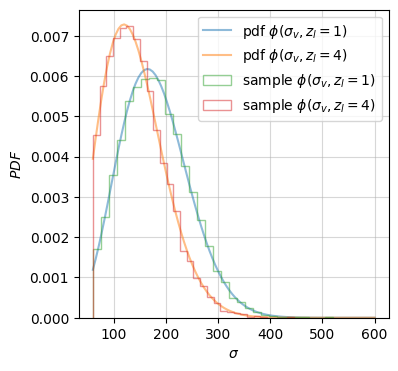

In [158]:
# plot velo disp pdf
plt.figure(figsize=(4,4))
plt.plot(sigma, sigma1, label=r"pdf $\phi(\sigma_v,z_l=1)$", alpha=0.5)
plt.plot(sigma, sigma4, label=r"pdf $\phi(\sigma_v,z_l=4)$", alpha=0.5)
# hist 
plt.hist(sample1, bins=30, alpha=0.5, density=True, histtype='step', label=r"sample $\phi(\sigma_v,z_l=1)$")
plt.hist(sample4, bins=30, alpha=0.5, density=True, histtype='step', label=r"sample $\phi(\sigma_v,z_l=4)$")
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$PDF$')   
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [170]:
# angular diameter distance
# Dc is the comoving distance
def angular_diameter_distance1(z):
    """
    Function to compute the angular diameter distance

    Parameters
    ----------
        z : `float`
            redshifts

    Returns
    -------
        D_A : `float`
            angular diameter distance

    """
    D_A = cosmo.angular_diameter_distance(z).value  # co-moving distance in Mpc

    return D_A

z = np.linspace(0.001, 10., 500)
%timeit test=angular_diameter_distance(z)
    

19.4 µs ± 157 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [171]:
# angular diameter distance
# Dc is the comoving distance
quad_ = []  # refers to integration (with quad algorithm) from scipy
H0d = cosmo._hubble_distance.value
for zl in z:
    quad_.append(
        quad(
            cosmo._inv_efunc_scalar,
            0.0,
            zl,
            args=cosmo._inv_efunc_scalar_args,
        )[0]* H0d / (zl + 1.0)
    )
quad_ = np.array(quad_)
angular_diameter_distance2 = interp1d(z, np.array(quad_), kind="cubic")

z = np.linspace(0.001, 10., 500)
%timeit test=angular_diameter_distance2(z)

19.5 µs ± 148 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [174]:
Da = lambda z_: cosmo.angular_diameter_distance(z_).value
angular_diameter_distance3 = interpolator_from_pickle(
            param_dict_given= dict(z_min=0.001, z_max=z_max, cosmology=cosmo), 
            directory="./interpolator",
            sub_directory="angular_diameter_distance", 
            name="angular_diameter_distance",
            x = z,
            pdf_func= Da, 
            conditioned_y=None, 
            dimension=1,
            category="function",
            create_new=True,
        )

angular_diameter_distance interpolator will be generated at ./interpolator/angular_diameter_distance/angular_diameter_distance_0.pickle


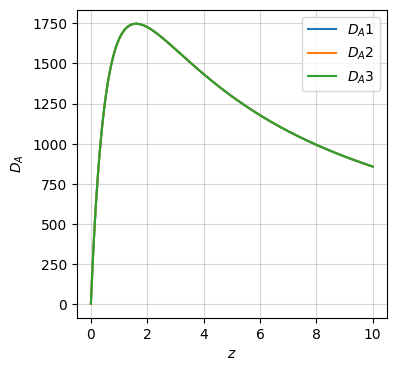

In [175]:
# plot
plt.figure(figsize=(4,4))
plt.plot(z, angular_diameter_distance1(z), label=r'$D_A1$')
plt.plot(z, angular_diameter_distance2(z), label=r'$D_A2$')
plt.plot(z, angular_diameter_distance3(z), label=r'$D_A3$')
plt.xlabel(r'$z$')
plt.ylabel(r'$D_A$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [176]:
def angular_diameter_distance_z1z21(zl_array, zs_array):
    list_ = []
    for zl,zs in zip(zl_array, zs_array):
        list_.append(cosmo.angular_diameter_distance_z1z2(zl, zs).value)

    return np.array(list_)

zl = np.linspace(0.001, 2., 500)
zs = np.ones(len(zl))*2

test1 = angular_diameter_distance_z1z21(zl, zs)

In [179]:
def angular_diameter_distance_z1z22(zl_array, zs_array):

    return (cosmo.angular_diameter_distance(zs_array).value*(1.+zs_array) - cosmo.angular_diameter_distance(zl_array).value*(1.+zl_array))/(1.+zs_array)
    # return cosmo.angular_diameter_distance(zs_array).value - cosmo.angular_diameter_distance(zl_array).value

zl = np.linspace(0.001, 2., 500)
zs = np.ones(len(zl))*2

test2 = angular_diameter_distance_z1z22(zl, zs)

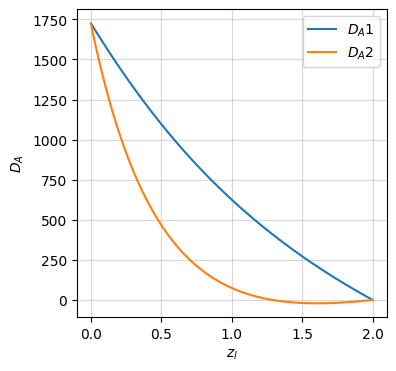

In [180]:
# plot
plt.figure(figsize=(4,4))
plt.plot(zl, test1, label=r'$D_A1$')
plt.plot(zl, test2, label=r'$D_A2$')
plt.xlabel(r'$z_l$')
plt.ylabel(r'$D_A$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [260]:
@njit
def cvdf_fit(log_vd, redshift):
    # from https://github.com/ptorrey/torrey_cmf/blob/master/torrey_cmf.py
    this_vars = np.array([
        [7.39149763, 5.72940031, -1.12055245],
        [-6.86339338, -5.27327109, 1.10411386],
        [2.85208259, 1.25569600, -0.28663846],
        [0.06703215, -0.04868317, 0.00764841]])
    coeffs = [this_vars[i][0] + this_vars[i][1] * redshift + this_vars[i][2] * redshift ** 2 for i in range(4)]
    mstar = log_vd - coeffs[3]
    return coeffs[0] + coeffs[1] * mstar + coeffs[2] * mstar ** 2 - np.exp(mstar)

In [240]:
from scipy.misc import derivative

def cvdf_fit_derivative(s,z):
    return derivative(lambda ss: cvdf_fit(ss, z), np.log10(s), dx=1e-8)

In [242]:
def myderivative(func, x0, dx=1.0, n=1, args=(), order=3):
    """
    Find the nth derivative of a function at a point.
    """
    # pre-computed for n=1 and 2 and low-order for speed.
    weights = np.array([-1, 0, 1]) / 2.0
    val = 0.0
    ho = order >> 1
    for k in range(order):
        val += weights[k] * func(x0 + (k - ho) * dx, *args)
    print(np.prod((dx,) * n, axis=0))
    return val / np.prod((dx,) * n, axis=0)

In [243]:
s = 161.
dx = 1e-8
0.5*(cvdf_fit(np.log10(s)+dx, 1.0)-cvdf_fit(np.log10(s)-dx, 1.0))/dx

-3.2196862953526306

In [241]:
cvdf_fit_derivative(s=161,z=1)

-3.2196862953526306

In [1]:
import numba
import scipy.special as sc
import numba_special  # The import generates Numba overloads for special
@numba.njit
def gamma_plus_1(x):
    return sc.gamma(x) + 1.0
gamma_plus_1(5.0)

ModuleNotFoundError: No module named 'numba_special'

## Numba

In [34]:
@njit
def gamma_(x):
    # Coefficients for the Lanczos approximation
    g = 7
    p = np.array([0.99999999999980993, 676.5203681218851, -1259.1392167224028,
                  771.32342877765313, -176.61502916214059, 12.507343278686905,
                  -0.13857109526572012, 9.9843695780195716e-6, 1.5056327351493116e-7])

    if x < 0.5:
        # Reflection formula
        return np.pi / (np.sin(np.pi * x) * gamma_(1 - x))
    else:
        x -= 1
        y = p[0]
        for i in range(1, g + 2):
            y += p[i] / (x + i)
        t = x + g + 0.5
        return np.sqrt(2 * np.pi) * t**(x + 0.5) * np.exp(-t) * y

In [25]:
gamma_(0.94/1.85)

1.7447396102979622

In [26]:
gamma(0.94/1.85)

1.7447396102979624

In [42]:
# # import gamma
from scipy.special import gamma

global cosmology_h
@njit
def cvdf_fit(log_vd, redshift):
    this_vars = np.array([
        [7.39149763, 5.72940031, -1.12055245],
        [-6.86339338, -5.27327109, 1.10411386],
        [2.85208259, 1.25569600, -0.28663846],
        [0.06703215, -0.04868317, 0.00764841]])
    coeffs = [this_vars[i][0] + this_vars[i][1] * redshift + this_vars[i][2] * redshift ** 2 for i in range(4)]
    mstar = log_vd - coeffs[3]
    return coeffs[0] + coeffs[1] * mstar + coeffs[2] * mstar ** 2 - np.exp(mstar)

@njit
def my_derivative(log_vd, redshift, dx):
    return 0.5 * (cvdf_fit(log_vd + dx, redshift) - cvdf_fit(log_vd - dx, redshift)) / dx

@njit
def pdf_phi_z_div_0(s, z):
    log_vd = np.log10(s)
    phi_sim_z = 10 ** cvdf_fit(log_vd, z) / s * my_derivative(log_vd, z, 1e-8)
    phi_sim_0 = 10 ** cvdf_fit(log_vd, 0) / s * my_derivative(log_vd, 0, 1e-8)
    return phi_sim_z / phi_sim_0

@njit
def phi_loc_bernardi(sigma, alpha=0.94, beta=1.85, phistar=2.099e-2, sigmastar=113.78):
    
    phistar = phistar * (cosmology_h / 0.7) ** 3  # Mpc**-3
    #phistar = phistar * (cosmo.h / 0.7) ** 3  # Mpc**-3
    philoc_ = phistar*(sigma/sigmastar)**alpha * np.exp(-(sigma/sigmastar)**beta) * beta/gamma_(alpha/beta)/sigma
    return philoc_


@njit
def phistar(s,z):
    return s**4*pdf_phi_z_div_0(s,z)*phi_loc_bernardi(s)

In [43]:
phi_loc_bernardi(161)

2.8634729381004674e-05

In [36]:
my_derivative(np.log10([11.0,161.0]), np.array([2.0,2.0]), 1e-8)

array([-7.04515244, -3.46811939])

In [37]:
cosmology_h = cosmo.h
cosmology_h
phi(s,z)

array([1.94153461e+03, 1.51774292e+04, 1.39028669e+04, 3.35235448e+03,
       1.87833777e+02, 2.33647654e+00, 8.48438396e-03, 1.60294352e-05,
       3.39079904e-08, 1.75732426e-10])

In [277]:
class Test():
    def __init__(self, cosmology):
        cosmology_h = cosmology
        pass

    def phi(self, s, z):
        cosmology_h 
        return phi(s,z)

NameError: name 'cosmology_h' is not defined

In [31]:
# make 2d array mesh of s and z
s = np.linspace(60., 600., 10)
z = np.linspace(0.001, 10., 10)
S, Z = np.meshgrid(s, z)

## JAX

In [18]:
import jax.numpy as jnp

from jax import grad, jit, vmap
from jax import random
# gamma from jax scipy
from jax.scipy.special import gamma 

@jit
def cvdf_fit(log_vd, redshift):
    this_vars = jnp.array([
        [7.39149763, 5.72940031, -1.12055245],
        [-6.86339338, -5.27327109, 1.10411386],
        [2.85208259, 1.25569600, -0.28663846],
        [0.06703215, -0.04868317, 0.00764841]])
    coeffs = [this_vars[i][0] + this_vars[i][1] * redshift + this_vars[i][2] * redshift ** 2 for i in range(4)]
    mstar = log_vd - coeffs[3]
    return coeffs[0] + coeffs[1] * mstar + coeffs[2] * mstar ** 2 - jnp.exp(mstar)

dlogVd_dz = grad(cvdf_fit, argnums=0)

print(dlogVd_dz(jnp.log10(11.0), 2.0))


In [267]:
%timeit test.my_cvdf_fit_derivative_method(S,Z)

7.62 µs ± 93.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [274]:
test = Test()
%timeit test.my_cvdf_fit_derivative_method(S,Z)

24.2 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [273]:
test = Test()
%timeit test.my_cvdf_fit_derivative_method(S,Z)

27.7 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [200]:
# 2D interpolation on the test function
# s: velocity dispersion, z: redshift
from scipy.interpolate import interp2d
s = np.linspace(60, 600, 100)
z = np.linspace(0.001, 10, 100)
X, Y = np.meshgrid(s, z)
Z = []
for z_ in z:
    Z.append(test(s,z_) )
Z = np.array(Z)
test2d = interp2d(s, z, Z, kind='cubic')


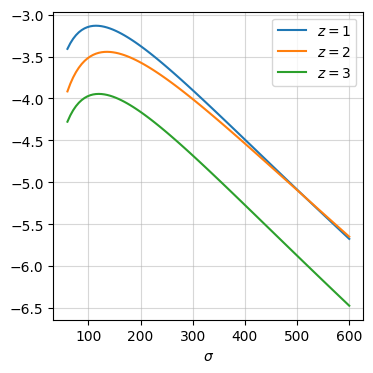

In [201]:
# plot
plt.figure(figsize=(4,4))
plt.plot(s, test(s,1), label=r'$z=1$')
plt.plot(s, test(s,2), label=r'$z=2$')
plt.plot(s, test(s,3), label=r'$z=3$')
plt.xlabel(r'$\sigma$')
#plt.ylabel(r'$\phi$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

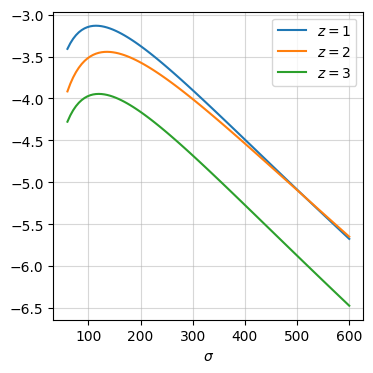

In [196]:
# plot
plt.figure(figsize=(4,4))
plt.plot(s, test(s,1), label=r'$z=1$')
plt.plot(s, test(s,2), label=r'$z=2$')
plt.plot(s, test(s,3), label=r'$z=3$')
plt.xlabel(r'$\sigma$')
#plt.ylabel(r'$\phi$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

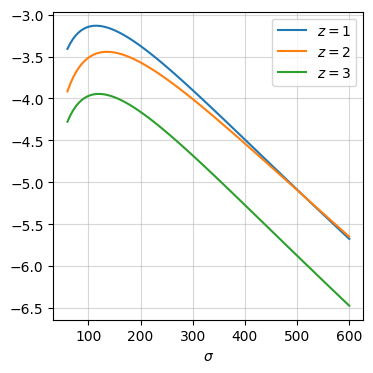

In [197]:
# plot
plt.figure(figsize=(4,4))
plt.plot(s, test2d(s,1), label=r'$z=1$')
plt.plot(s, test2d(s,2), label=r'$z=2$')
plt.plot(s, test2d(s,3), label=r'$z=3$')
plt.xlabel(r'$\sigma$')
#plt.ylabel(r'$\phi$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()